### Import packages

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns

from pyspark import SparkContext, SparkConf


%matplotlib inline

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r

### Run code below only for the first folder (i.e. creation of image and classification arrays)

In [2]:
classification=np.array([])

expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180511_Turnover_Bic_nb580first_635psecond/TNR/' #master folder

early_channel_no=2 #channel number of early incubation colour
late_channel_no=3 #channel number of late incubation colour

#make a dictionary of all images in the experiment
results = {"filename":[], "exp_condition":[]}
filelist = []
for root, _, filenames in os.walk(expdir):
    for filename in filenames:
        filelist.append(os.path.join(root, filename))
    for i in range(0,len(filelist)):
        if filelist[i].endswith(".nd2"):
            results["filename"].append(filelist[i])
            results["exp_condition"].append(filelist[i].split('/')[-2])

#create the images array by adding the first bic image           
for condition in np.unique(results["exp_condition"]):
    #make dictionary for files in this condition only
    exp_condition_images = [results["filename"][idx] for idx, x in enumerate(results["exp_condition"]) if x == condition ]
    exp_condition_images=np.unique(exp_condition_images)
    no_images_cond=len(exp_condition_images)
    a= ['1DayBic', '1Day_Bic', '1daybic','1DayBic','1dayBic','1day_bic','1day_Bic','1Day_bic','1day_bic']
    b=['1Day_Untreated','1day_Untreated','1Day_DMSO','1day_DMSO']
    if any(l in str(condition) for l in a):
        #first bic image
        with ND2Reader(results["filename"][0]) as images:
            #read the images
            early_image=images[early_channel_no-1]
            late_image=images[late_channel_no-1]
            #convert to array
            early_image=early_image.astype(np.int16)
            late_image=late_image.astype(np.int16)
            #split images into 4 equal parts
            early_1=early_image[0:255,0:255]
            late_1=late_image[0:255,0:255]
            Image1=np.stack([early_1,late_1],axis=-1)
            All_Images=Image1 #append to image array
            classification=np.append(arr=classification,values=1) #append to classification array
            early_2=early_image[0:255,0:255]
            late_2=late_image[0:255,256:-1]
            Image2=np.stack([early_2,late_2],axis=-1)
            All_Images=np.stack([All_Images,Image2],axis=0)
            classification=np.append(arr=classification,values=1) 
            early_3=early_image[256:-1,0:255]
            late_3=late_image[256:-1,0:255]
            Image3=np.stack([early_3,late_3],axis=-1)
            All_Images=np.append(All_Images,[Image3],axis=0)
            classification=np.append(arr=classification,values=1)
            early_4=early_image[256:-1,256:-1]
            late_4=late_image[256:-1,256:-1]
            Image4=np.stack([early_4,late_4],axis=-1)
            All_Images=np.append(All_Images,[Image4],axis=0)
            classification=np.append(arr=classification,values=1)
            
        break

#Continue by appending image 1:-1 of bic and 0:-1 of control

for condition in np.unique(results["exp_condition"]):
    #make dictionary for files in this condition only
    exp_condition_images = [results["filename"][idx] for idx, x in enumerate(results["exp_condition"]) if x == condition ]
    exp_condition_images=np.unique(exp_condition_images)
    no_images_cond=len(exp_condition_images)
    a= ['1DayBic', '1Day_Bic', '1daybic','1DayBic','1dayBic','1day_bic','1day_Bic','1Day_bic','1day_bic']
    b=['1Day_Untreated','1day_Untreated','1Day_DMSO','1day_DMSO']
    
    if any(l in str(condition) for l in a):
        for i in range(1,no_images_cond):
            print("Image no "+str(i+1)+" out of "+str(no_images_cond))
            with ND2Reader(results["filename"][i]) as images:
                #read the images
                early_image=images[early_channel_no-1]
                late_image=images[late_channel_no-1]
                #convert to array
                early_image=early_image.astype(np.int16)
                late_image=late_image.astype(np.int16)
                #split images into 4 equal parts
                early_1=early_image[0:255,0:255]
                late_1=late_image[0:255,0:255]
                Image1=np.stack([early_1,late_1],axis=-1)
                All_Images=np.append(All_Images,[Image1],axis=0)
                classification=np.append(arr=classification,values=1) #append to classification array
                early_2=early_image[0:255,0:255]
                late_2=late_image[0:255,256:-1]
                Image2=np.stack([early_2,late_2],axis=-1)
                All_Images=np.append(All_Images,[Image2],axis=0)
                classification=np.append(arr=classification,values=1) 
                early_3=early_image[256:-1,0:255]
                late_3=late_image[256:-1,0:255]
                Image3=np.stack([early_3,late_3],axis=-1)
                All_Images=np.append(All_Images,[Image3],axis=0)
                classification=np.append(arr=classification,values=1)
                early_4=early_image[256:-1,256:-1]
                late_4=late_image[256:-1,256:-1]
                Image4=np.stack([early_4,late_4],axis=-1)
                All_Images=np.append(All_Images,[Image4],axis=0)
                classification=np.append(arr=classification,values=1)
        continue
    if any(l in str(condition) for l in b):
        for i in range(0,no_images_cond):
            print("Image no "+str(i+1)+" out of "+str(no_images_cond))
            with ND2Reader(results["filename"][i]) as images:
                #read the images
                early_image=images[early_channel_no-1]
                late_image=images[late_channel_no-1]
                #convert to array
                early_image=early_image.astype(np.int16)
                late_image=late_image.astype(np.int16)
                #split images into 4 equal parts
                early_1=early_image[0:255,0:255]
                late_1=late_image[0:255,0:255]
                Image1=np.stack([early_1,late_1],axis=-1)
                All_Images=np.append(All_Images,[Image1],axis=0)
                classification=np.append(arr=classification,values=0) #append to classification array
                early_2=early_image[0:255,0:255]
                late_2=late_image[0:255,256:-1]
                Image2=np.stack([early_2,late_2],axis=-1)
                All_Images=np.append(All_Images,[Image2],axis=0)
                classification=np.append(arr=classification,values=0) 
                early_3=early_image[256:-1,0:255]
                late_3=late_image[256:-1,0:255]
                Image3=np.stack([early_3,late_3],axis=-1)
                All_Images=np.append(All_Images,[Image3],axis=0)
                classification=np.append(arr=classification,values=0)
                early_4=early_image[256:-1,256:-1]
                late_4=late_image[256:-1,256:-1]
                Image4=np.stack([early_4,late_4],axis=-1)
                All_Images=np.append(All_Images,[Image4],axis=0)
                classification=np.append(arr=classification,values=0)
            continue

Image no 2 out of 28
Image no 3 out of 28
Image no 4 out of 28
Image no 5 out of 28
Image no 6 out of 28
Image no 7 out of 28
Image no 8 out of 28
Image no 9 out of 28
Image no 10 out of 28
Image no 11 out of 28
Image no 12 out of 28
Image no 13 out of 28
Image no 14 out of 28
Image no 15 out of 28
Image no 16 out of 28
Image no 17 out of 28
Image no 18 out of 28
Image no 19 out of 28
Image no 20 out of 28
Image no 21 out of 28
Image no 22 out of 28
Image no 23 out of 28
Image no 24 out of 28
Image no 25 out of 28
Image no 26 out of 28
Image no 27 out of 28
Image no 28 out of 28
Image no 1 out of 30
Image no 2 out of 30
Image no 3 out of 30
Image no 4 out of 30
Image no 5 out of 30
Image no 6 out of 30
Image no 7 out of 30
Image no 8 out of 30
Image no 9 out of 30
Image no 10 out of 30
Image no 11 out of 30
Image no 12 out of 30
Image no 13 out of 30
Image no 14 out of 30
Image no 15 out of 30
Image no 16 out of 30
Image no 17 out of 30
Image no 18 out of 30
Image no 19 out of 30
Image

In [3]:
classification.shape

(232,)

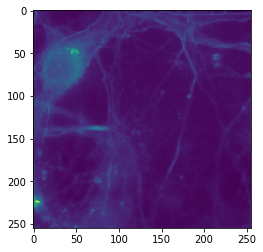

In [4]:
plt.imshow(All_Images[110,:,:,0])

### Run below for sequential folders

In [11]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20180214_Turnover_Bic_TNR_nb580first_nb653psecond/' #master folder

early_channel_no=2 #channel number of early incubation colour
late_channel_no=1 #channel number of late incubation colour

#make a dictionary of all images in the experiment
results = {"filename":[], "exp_condition":[]}
filelist = []
for root, _, filenames in os.walk(expdir):
    for filename in filenames:
        filelist.append(os.path.join(root, filename))
    for i in range(0,len(filelist)):
        if filelist[i].endswith(".nd2"):
            results["filename"].append(filelist[i])
            results["exp_condition"].append(filelist[i].split('/')[-2])

In [12]:
for condition in np.unique(results["exp_condition"]):
    #make dictionary for files in this condition only
    exp_condition_images = [results["filename"][idx] for idx, x in enumerate(results["exp_condition"]) if x == condition ]
    exp_condition_images=np.unique(exp_condition_images)
    no_images_cond=len(exp_condition_images)
    a= ['1DayBic', '1Day_Bic', '1daybic','1DayBic','1dayBic','1day_bic','1day_Bic','1Day_bic','1day_bic']
    b=['1Day_Untreated','1day_Untreated','1Day_DMSO','1day_DMSO']
    
    if any(l in str(condition) for l in a):
        for i in range(0,no_images_cond):
            print("Image no "+str(i+1)+" out of "+str(no_images_cond))
            with ND2Reader(results["filename"][i]) as images:
                #read the images
                early_image=images[early_channel_no-1]
                late_image=images[late_channel_no-1]
                #convert to array
                early_image=early_image.astype(np.int16)
                late_image=late_image.astype(np.int16)
                #split images into 4 equal parts
                early_1=early_image[0:255,0:255]
                late_1=late_image[0:255,0:255]
                Image1=np.stack([early_1,late_1],axis=-1)
                All_Images=np.append(All_Images,[Image1],axis=0)
                classification=np.append(arr=classification,values=1) #append to classification array
                early_2=early_image[0:255,0:255]
                late_2=late_image[0:255,256:-1]
                Image2=np.stack([early_2,late_2],axis=-1)
                All_Images=np.append(All_Images,[Image2],axis=0)
                classification=np.append(arr=classification,values=1) 
                early_3=early_image[256:-1,0:255]
                late_3=late_image[256:-1,0:255]
                Image3=np.stack([early_3,late_3],axis=-1)
                All_Images=np.append(All_Images,[Image3],axis=0)
                classification=np.append(arr=classification,values=1)
                early_4=early_image[256:-1,256:-1]
                late_4=late_image[256:-1,256:-1]
                Image4=np.stack([early_4,late_4],axis=-1)
                All_Images=np.append(All_Images,[Image4],axis=0)
                classification=np.append(arr=classification,values=1)
        continue
    if any(l in str(condition) for l in b):
        for i in range(0,no_images_cond):
            print("Image no "+str(i+1)+" out of "+str(no_images_cond))
            with ND2Reader(results["filename"][i]) as images:
                #read the images
                early_image=images[early_channel_no-1]
                late_image=images[late_channel_no-1]
                #convert to array
                early_image=early_image.astype(np.int16)
                late_image=late_image.astype(np.int16)
                #split images into 4 equal parts
                early_1=early_image[0:255,0:255]
                late_1=late_image[0:255,0:255]
                Image1=np.stack([early_1,late_1],axis=-1)
                All_Images=np.append(All_Images,[Image1],axis=0)
                classification=np.append(arr=classification,values=0) #append to classification array
                early_2=early_image[0:255,0:255]
                late_2=late_image[0:255,256:-1]
                Image2=np.stack([early_2,late_2],axis=-1)
                All_Images=np.append(All_Images,[Image2],axis=0)
                classification=np.append(arr=classification,values=0) 
                early_3=early_image[256:-1,0:255]
                late_3=late_image[256:-1,0:255]
                Image3=np.stack([early_3,late_3],axis=-1)
                All_Images=np.append(All_Images,[Image3],axis=0)
                classification=np.append(arr=classification,values=0)
                early_4=early_image[256:-1,256:-1]
                late_4=late_image[256:-1,256:-1]
                Image4=np.stack([early_4,late_4],axis=-1)
                All_Images=np.append(All_Images,[Image4],axis=0)
                classification=np.append(arr=classification,values=0)
            continue

Image no 1 out of 14
Image no 2 out of 14
Image no 3 out of 14
Image no 4 out of 14
Image no 5 out of 14
Image no 6 out of 14
Image no 7 out of 14
Image no 8 out of 14
Image no 9 out of 14
Image no 10 out of 14
Image no 11 out of 14
Image no 12 out of 14
Image no 13 out of 14
Image no 14 out of 14
Image no 1 out of 15
Image no 2 out of 15
Image no 3 out of 15
Image no 4 out of 15
Image no 5 out of 15
Image no 6 out of 15
Image no 7 out of 15
Image no 8 out of 15
Image no 9 out of 15
Image no 10 out of 15
Image no 11 out of 15
Image no 12 out of 15
Image no 13 out of 15
Image no 14 out of 15
Image no 15 out of 15


In [14]:
# Save numpy files
np.save('classification.npy', classification)
np.save('All_Images.npy',All_Images)

In [15]:
#Print dimensions
print('All images shape '+str(All_Images.shape))
print('Classifications array shape '+str(classification.shape))

All images shape (1156, 255, 255, 2)
Classifications array shape (1156,)


## AlexNet with keras

In [16]:
# (1) Importing dependency
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
np.random.seed(1000)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [69]:
# (2) Get Data
import tflearn.datasets.oxflower17 as oxflower17
x, y = oxflower17.load_data(one_hot=True)


In [75]:
y[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [73]:
x.shape

(1360, 224, 224, 3)

In [17]:
x=All_Images
y=classification

In [29]:
classification.shape

(1156,)

In [44]:
classdouble=np.ones(,2)
for i in range(0,len(y)):
        if y[i]==1:
            classdouble=np.append(arr=classdouble,values=[1,0],axis=0) 
        if y[i]==0:
            classdouble=np.append(arr=classdouble,values=[0,1],axis=0) 

SyntaxError: invalid syntax (<ipython-input-44-fe3cea4b45e1>, line 1)

In [55]:
def all_idx(idx, axis):
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)
def onehot_initialization(a):
    ncols = a.max()+1
    out = np.zeros(a.shape + (ncols,), dtype=int)
    out[all_idx(a, axis=2)] = 1
    return out

In [56]:
classint=classification.astype(int)
classdouble=onehot_initialization(classint)
classdouble.shape

(1156, 2)

In [64]:
#classification[1000:1005]
classdouble[1000:1005,:]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [65]:
y=classdouble

In [66]:
# (3) Create a sequential model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(255,255,2), kernel_size=(11,11),\
 strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 96)        23328     
_________________________________________________________________
activation_19 (Activation)   (None, 62, 62, 96)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 96)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 31, 31, 96)        384       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 21, 21, 256)       2973952   
_________________________________________________________________
activation_20 (Activation)   (None, 21, 21, 256)       0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 256)       0         
__________

In [67]:
# (4) Compile 
model.compile(loss='categorical_crossentropy', optimizer='adam',\
 metrics=['accuracy'])

In [68]:
# (5) Train
history=model.fit(x, y, batch_size=24, epochs=30, verbose=1, \
validation_split=0.25, shuffle=True)

Train on 867 samples, validate on 289 samples
Epoch 1/30
867/867 [==============================] - 230s 265ms/step - loss: 1.5519 - acc: 0.5098 - val_loss: 8.9297 - val_acc: 0.3772
Epoch 2/30
867/867 [==============================] - 199s 229ms/step - loss: 0.9556 - acc: 0.4971 - val_loss: 1.1723 - val_acc: 0.3910
Epoch 3/30
867/867 [==============================] - 192s 222ms/step - loss: 0.9116 - acc: 0.5190 - val_loss: 6.1879 - val_acc: 0.3772
Epoch 4/30
867/867 [==============================] - 200s 231ms/step - loss: 0.8629 - acc: 0.5225 - val_loss: 4.1458 - val_acc: 0.3841
Epoch 5/30
867/867 [==============================] - 204s 235ms/step - loss: 0.9084 - acc: 0.5098 - val_loss: 4.6055 - val_acc: 0.3772
Epoch 6/30
867/867 [==============================] - 203s 234ms/step - loss: 0.8256 - acc: 0.4948 - val_loss: 1.5018 - val_acc: 0.3841
Epoch 7/30
867/867 [==============================] - 187s 215ms/step - loss: 0.7930 - acc: 0.4971 - val_loss: 1.3110 - val_acc: 0.4256
Ep

KeyboardInterrupt: 

In [ ]:
# list all data in history
print(history.history.keys())


In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()